#Snake Identifier


## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
LE = LabelEncoder()

import tensorflow as tf
!pip install --upgrade tensorflow_hub
import tensorflow_hub as hub
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models  import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications import vgg16
from tensorflow.keras.applications import VGG16 # Wtf ?
from keras.optimizers import Adam

from google.colab import drive
import h5py

%matplotlib inline

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.7/dist-packages (0.12.0)


In [ ]:
drive.mount('/content/drive',force_remount=True)
BASE_PATH ="/content/drive/MyDrive/data"

Mounted at /content/drive


## Data exploration

- Loading dataframe

In [ ]:
path = BASE_PATH+"/oficial/data.csv"
df = pd.read_csv(path)
df['breed_encode'] = LE.fit_transform(df['breed'])

- Main dataframe:

In [ ]:
df.head()

,image_id,breed,breed_encode
0,a8b3ad1dde,nerodia-erythrogaster,15
1,8b492b973d,pantherophis-vulpinus,25
2,929b99ea92,thamnophis-sirtalis,34
3,bbac7385e2,pantherophis-obsoletus,23
4,ef776b1488,agkistrodon-contortrix,0


- Data Size

In [ ]:
df.shape

(20845, 3)

- Breeds:

In [ ]:
print(pd.unique(df['breed']));
print("Total breeds",len ( pd.unique(df['breed'])));

['nerodia-erythrogaster' 'pantherophis-vulpinus' 'thamnophis-sirtalis'
 'pantherophis-obsoletus' 'agkistrodon-contortrix' 'crotalus-atrox'
 'lampropeltis-triangulum' 'crotalus-horridus' 'crotalus-ruber'
 'heterodon-platirhinos' 'nerodia-sipedon' 'thamnophis-elegans'
 'thamnophis-marcianus' 'crotalus-viridis' 'nerodia-fasciata'
 'haldea-striatula' 'storeria-dekayi' 'agkistrodon-piscivorus'
 'nerodia-rhombifer' 'storeria-occipitomaculata' 'thamnophis-radix'
 'coluber-constrictor' 'natrix-natrix' 'diadophis-punctatus'
 'masticophis-flagellum' 'pantherophis-spiloides' 'rhinocheilus-lecontei'
 'lampropeltis-californiae' 'pituophis-catenifer' 'opheodrys-aestivus'
 'pantherophis-guttatus' 'pantherophis-alleghaniensis'
 'thamnophis-proximus' 'pantherophis-emoryi' 'crotalus-scutulatus']
Total breeds 35


- Total images for each breed : 

In [ ]:
print(df['breed'].value_counts())

thamnophis-sirtalis            972
storeria-dekayi                882
crotalus-atrox                 837
pantherophis-obsoletus         812
pituophis-catenifer            735
lampropeltis-triangulum        695
nerodia-sipedon                691
agkistrodon-contortrix         643
diadophis-punctatus            631
agkistrodon-piscivorus         630
nerodia-erythrogaster          616
pantherophis-alleghaniensis    615
lampropeltis-californiae       610
opheodrys-aestivus             608
coluber-constrictor            591
heterodon-platirhinos          585
pantherophis-guttatus          580
crotalus-horridus              577
natrix-natrix                  573
masticophis-flagellum          553
haldea-striatula               550
storeria-occipitomaculata      540
nerodia-rhombifer              536
thamnophis-proximus            534
rhinocheilus-lecontei          526
crotalus-ruber                 503
crotalus-scutulatus            503
thamnophis-radix               499
pantherophis-vulpinu

- Datad density:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


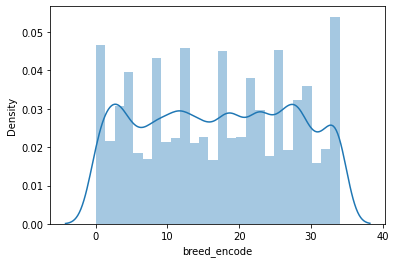

In [ ]:
sns.distplot(df['breed_encode']);

- Histogram:

(array([2701., 1583., 2224., 1858., 1644., 2450., 1851., 2240., 1860.,
        2434.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <a list of 10 Patch objects>)

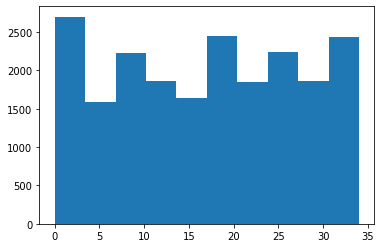

In [ ]:
plt.hist(df['breed_encode'])

## Convolutional network arquitecture

### Transfer learning

- Get model Using VGG16 Arquitecture

In [ ]:
#Custom model
def getModel ( num_breeds ) :

  vgg= VGG16( 
      input_shape= (224,224,3), 
      weights='imagenet',
      include_top=False
      )
  
 # layer_flatten = Flatten()(vgg.output)

  vgg.summary()
  custom_model=vgg

  for layer in custom_model.layers:
    layer.trainable = False
      


  last_layer = Flatten()(custom_model.output)
  last_layer = Dense(512, activation='relu', name='full_connected_1')(last_layer)
  #last_layer = Dropout(0.5)(last_layer)
  last_layer = Dense(128, activation='relu', name='full_connected_2')(last_layer)
  out = Dense(num_breeds, activation='softmax', name='output')(last_layer)
  custom_model = Model(custom_model.input, out)


  
  opt = Adam(lr=0.001) #Stochastic gradient descent
  custom_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  custom_model.summary()

  

  return custom_model

In [ ]:
model = getModel( num_breeds = 35 )

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Loading Data


In [ ]:

for i in range(1,11):

    destination_filepath = BASE_PATH+'/batchs/'+'snakes_'+str(i)+'.h5'
    with h5py.File(destination_filepath, "r") as f:
        
        print("Group:",i)
        
        x = f["input_data"][:]
        y = f["input_labels"][:]
        x=x.reshape(x.shape[0],224,224,3)
        x=preprocess_input(x*255)
        
        #print('x shape =', x.shape, '| y shape =', y.shape)


    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20)
    train(model,x_train,y_train,x_test,y_test , batch_size=32, epochs=10, model_name="modelA")
    #print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    #print("\nDistribution of train classes")
    #print(pd.Series(y_train).value_counts())
    #print("\nDistribution of test classes")
    #print(pd.Series(y_test).value_counts())

Group: 1
Epoch 1/10
52/52 [==============================] - 9s 159ms/step - loss: 10.0342 - accuracy: 0.0549 - val_loss: 3.5586 - val_accuracy: 0.0366
Epoch 2/10
52/52 [==============================] - 8s 155ms/step - loss: 3.4804 - accuracy: 0.0836 - val_loss: 3.7255 - val_accuracy: 0.0439
Epoch 3/10
52/52 [==============================] - 8s 156ms/step - loss: 3.3838 - accuracy: 0.0958 - val_loss: 3.5049 - val_accuracy: 0.0390
Epoch 4/10
52/52 [==============================] - 8s 156ms/step - loss: 3.3278 - accuracy: 0.1044 - val_loss: 3.4993 - val_accuracy: 0.0463
Epoch 5/10
52/52 [==============================] - 8s 156ms/step - loss: 3.2277 - accuracy: 0.1123 - val_loss: 3.5610 - val_accuracy: 0.0683
Epoch 6/10
52/52 [==============================] - 8s 156ms/step - loss: 3.1702 - accuracy: 0.1374 - val_loss: 3.4427 - val_accuracy: 0.0561
Epoch 7/10
52/52 [==============================] - 8s 156ms/step - loss: 3.1335 - accuracy: 0.1538 - val_loss: 3.7927 - val_accuracy: 0.0

# Training

In [ ]:
def train(model,x_train,y_train,x_test,y_test , batch_size, epochs, model_name=""):
    model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

Predict with VGG16 - No custom


In [ ]:

df_decode = pd.read_csv('decode_breed_noid.csv')
modelo=VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

i =  0#random.randint(0,1024)
print(df_decode['breed'][y[i]])
plt.imshow(xx[i])

image=xx[:1]*255
# prepare the image for the VGG model
image = preprocess_input(image) 
#print(image)
# predict the probability across all output classes
yhat = modelo.predict(image)
print(yhat.sum(axis=1))
# convert the probabilities to class labels
label = decode_predictions(yhat)
print(label[i])
# retrieve the most likely result, e.g. highest probabili

FileNotFoundError: ignored